In [1]:
pip install gymnasium numpy


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 965 kB 1.5 MB/s eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class GridVictimEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, grid_size=5, num_victims=3):
        super(GridVictimEnv, self).__init__()

        self.grid_size = grid_size
        self.num_victims = num_victims

        # Agent position (x, y)
        self.agent_pos = None

        # Victims are randomly placed
        self.victims = None

        # 4 actions: up, down, left, right
        self.action_space = spaces.Discrete(4)

        # Observation: agent's position + grid state (flattened)
        self.observation_space = spaces.Dict({
            "agent": spaces.Box(low=0, high=grid_size - 1, shape=(2,), dtype=np.int32),
            "victims": spaces.MultiBinary(grid_size * grid_size)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        self.agent_pos = np.array([0, 0])
        self.victims = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)

        # Randomly place victims
        placed = 0
        while placed < self.num_victims:
            x, y = np.random.randint(self.grid_size, size=2)
            if self.victims[x, y] == 0 and (x != 0 or y != 0):
                self.victims[x, y] = 1
                placed += 1

        return self._get_obs(), {}

    def step(self, action):
        # Move agent
        x, y = self.agent_pos
        if action == 0 and x > 0: x -= 1      # up
        elif action == 1 and x < self.grid_size - 1: x += 1  # down
        elif action == 2 and y > 0: y -= 1    # left
        elif action == 3 and y < self.grid_size - 1: y += 1  # right

        self.agent_pos = np.array([x, y])

        reward = 0
        done = False

        if self.victims[x, y] == 1:
            reward = 1
            self.victims[x, y] = 0  # rescue victim
            if self.victims.sum() == 0:
                done = True  # all victims rescued

        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        return {
            "agent": self.agent_pos,
            "victims": self.victims.flatten()
        }

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".")
        for x in range(self.grid_size):
            for y in range(self.grid_size):
                if self.victims[x, y] == 1:
                    grid[x, y] = "V"
        x, y = self.agent_pos
        grid[x, y] = "A"
        print("\n".join(" ".join(row) for row in grid))
        print("---")

    def close(self):
        pass


In [3]:
env = GridVictimEnv(grid_size=5, num_victims=3)
obs, _ = env.reset()
done = False

while not done:
    env.render()
    action = env.action_space.sample()  # random action
    obs, reward, done, _, _ = env.step(action)
    print("Action:", action, "| Reward:", reward)


A . . . V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 3 | Reward: 0
. A . . V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 0 | Reward: 0
. A . . V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 3 | Reward: 0
. . A . V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 0 | Reward: 0
. . A . V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 3 | Reward: 0
. . . A V
V . . . .
. . . . .
. . . . V
. . . . .
---
Action: 1 | Reward: 0
. . . . V
V . . A .
. . . . .
. . . . V
. . . . .
---
Action: 3 | Reward: 0
. . . . V
V . . . A
. . . . .
. . . . V
. . . . .
---
Action: 1 | Reward: 0
. . . . V
V . . . .
. . . . A
. . . . V
. . . . .
---
Action: 3 | Reward: 0
. . . . V
V . . . .
. . . . A
. . . . V
. . . . .
---
Action: 1 | Reward: 1
. . . . V
V . . . .
. . . . .
. . . . A
. . . . .
---
Action: 3 | Reward: 0
. . . . V
V . . . .
. . . . .
. . . . A
. . . . .
---
Action: 3 | Reward: 0
. . . . V
V . . . .
. . . . .
. . . . A
. . . . .
---
Action: 1 | Reward: 0
. . . . V
V 

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class MultiUAVGridEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, grid_size=5, num_victims=5, num_uavs=2):
        super(MultiUAVGridEnv, self).__init__()
        self.grid_size = grid_size
        self.num_victims = num_victims
        self.num_uavs = num_uavs

        self.agent_positions = None
        self.victims = None

        # Each UAV has 4 actions (up, down, left, right)
        self.action_space = spaces.MultiDiscrete([4] * num_uavs)

        # Observations: agent positions + flattened victim grid
        self.observation_space = spaces.Dict({
            "agents": spaces.Box(low=0, high=grid_size - 1, shape=(num_uavs, 2), dtype=np.int32),
            "victims": spaces.MultiBinary(grid_size * grid_size)
        })

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.agent_positions = []

        # Place UAVs
        for i in range(self.num_uavs):
            self.agent_positions.append(np.array([0, i]))  # spread on top row

        self.agent_positions = np.array(self.agent_positions)
        self.victims = np.zeros((self.grid_size, self.grid_size), dtype=np.int32)

        # Place victims randomly
        placed = 0
        while placed < self.num_victims:
            x, y = np.random.randint(self.grid_size, size=2)
            if self.victims[x, y] == 0 and not any((ap == [x, y]).all() for ap in self.agent_positions):
                self.victims[x, y] = 1
                placed += 1

        return self._get_obs(), {}

    def step(self, actions):
        rewards = [0] * self.num_uavs
        done = False

        # Move all agents
        for idx, action in enumerate(actions):
            x, y = self.agent_positions[idx]

            if action == 0 and x > 0: x -= 1       # up
            elif action == 1 and x < self.grid_size - 1: x += 1   # down
            elif action == 2 and y > 0: y -= 1     # left
            elif action == 3 and y < self.grid_size - 1: y += 1   # right

            self.agent_positions[idx] = [x, y]

            # Rescue victim
            if self.victims[x, y] == 1:
                self.victims[x, y] = 0
                rewards[idx] = 1

        if self.victims.sum() == 0:
            done = True

        total_reward = sum(rewards)
        return self._get_obs(), total_reward, done, False, {}

    def _get_obs(self):
        return {
            "agents": self.agent_positions.copy(),
            "victims": self.victims.flatten()
        }

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".", dtype=str)

        for x, y in zip(self.agent_positions[:, 0], self.agent_positions[:, 1]):
            grid[x, y] = "A"

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.victims[i, j] == 1:
                    if grid[i, j] == "A":
                        grid[i, j] = "*"
                    else:
                        grid[i, j] = "V"

        print("\n".join(" ".join(row) for row in grid))
        print("---")

    def close(self):
        pass


In [5]:
env = MultiUAVGridEnv(grid_size=5, num_victims=5, num_uavs=2)
obs, _ = env.reset()
done = False

while not done:
    env.render()
    actions = env.action_space.sample()  # Random actions for each UAV
    obs, reward, done, _, _ = env.step(actions)
    print("Actions:", actions, "| Reward:", reward)


A A . . V
. V . . .
. . V . .
. . . V .
. . V . .
---
Actions: [3 0] | Reward: 0
. A . . V
. V . . .
. . V . .
. . . V .
. . V . .
---
Actions: [3 2] | Reward: 0
A . A . V
. V . . .
. . V . .
. . . V .
. . V . .
---
Actions: [3 0] | Reward: 0
A . . A V
. V . . .
. . V . .
. . . V .
. . V . .
---
Actions: [1 3] | Reward: 0
. A . . V
. V . A .
. . V . .
. . . V .
. . V . .
---
Actions: [3 0] | Reward: 0
. A . . V
. V . . A
. . V . .
. . . V .
. . V . .
---
Actions: [3 2] | Reward: 0
A . . . V
. V . . A
. . V . .
. . . V .
. . V . .
---
Actions: [3 3] | Reward: 0
. A . . V
. V . . A
. . V . .
. . . V .
. . V . .
---
Actions: [0 0] | Reward: 1
. A . . A
. V . . .
. . V . .
. . . V .
. . V . .
---
Actions: [3 1] | Reward: 1
. . . . A
. A . . .
. . V . .
. . . V .
. . V . .
---
Actions: [2 3] | Reward: 0
. . . A .
. . A . .
. . V . .
. . . V .
. . V . .
---
Actions: [3 1] | Reward: 1
. . . . A
. . . . .
. . A . .
. . . V .
. . V . .
---
Actions: [1 1] | Reward: 0
. . . . .
. . . . A
. . . . 

In [7]:
pip install gymnasium matplotlib


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
import time

def draw_grid(env, delay=0.5):
    grid_size = env.grid_size
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(range(grid_size + 1))
    ax.set_yticks(range(grid_size + 1))
    ax.grid(True)

    # Draw victims
    for i in range(grid_size):
        for j in range(grid_size):
            if env.victims[i, j] == 1:
                ax.add_patch(patches.Circle((j + 0.5, grid_size - 1 - i + 0.5), 0.2, color='red'))

    # Draw UAVs
    for idx, (x, y) in enumerate(env.agent_positions):
        ax.add_patch(patches.Rectangle((y + 0.1, grid_size - 1 - x + 0.1), 0.8, 0.8, color='blue'))
        ax.text(y + 0.5, grid_size - 1 - x + 0.5, f"A{idx}", ha='center', va='center', color='white', fontsize=12)

    ax.set_title("UAV Rescue Simulation")
    plt.pause(delay)
    plt.show()


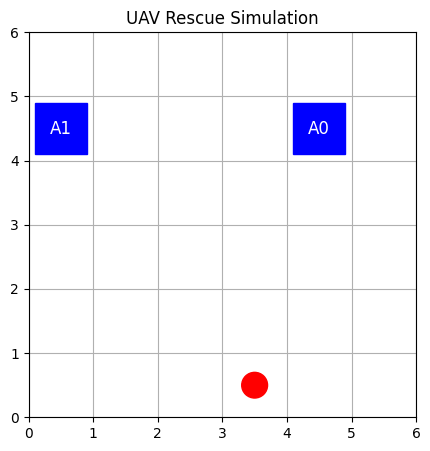

Step 49 | Actions: [2 3] | Reward: 0


In [10]:
env = MultiUAVGridEnv(grid_size=6, num_victims=5, num_uavs=2)
obs, _ = env.reset()

done = False
step_count = 0

while not done and step_count < 50:
    clear_output(wait=True)
    draw_grid(env, delay=0.4)
    
    actions = env.action_space.sample()  # Random actions
    obs, reward, done, _, _ = env.step(actions)
    
    print(f"Step {step_count} | Actions: {actions} | Reward: {reward}")
    step_count += 1

env.close()


In [2]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

In [5]:
df=pd.read_csv('/Users/adyant/Desktop/arc/T1L.csv')

In [6]:
df.head

<bound method NDFrame.head of      Temperature
0          25.70
1          26.30
2          26.40
3          26.45
4          26.50
..           ...
597        50.15
598        50.31
599        50.35
600        50.44
601        50.51

[602 rows x 1 columns]>

In [8]:
!pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.5/252.5 MB 4.8 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 5.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8/8 [tensorflow]8 [tensorflow]


In [3]:
pip install aif360


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import pandas as pd
import numpy as np

from aif360.datasets import StandardDataset, BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


# =====================================================
# Utility: run fairness pipeline
# =====================================================
def run_fairness_pipeline(df, label_name, favorable_classes,
                          protected_attr, privileged_vals, unprivileged_vals):
    """Runs baseline, unmitigated, and reweighed fairness analysis."""
    
    # Ensure categorical variables are encoded
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Build StandardDataset
    dataset = StandardDataset(
        df_encoded,
        label_name=label_name,
        favorable_classes=favorable_classes,
        protected_attribute_names=[protected_attr],
        privileged_classes=[privileged_vals],
    )

    dataset_train, dataset_test = dataset.split([0.7], shuffle=True)

    # --- Before mitigation ---
    metric_train = BinaryLabelDatasetMetric(
        dataset_train,
        privileged_groups=[{protected_attr: privileged_vals[0]}],
        unprivileged_groups=[{protected_attr: unprivileged_vals[0]}]
    )
    print("\n=== BEFORE MITIGATION ===")
    print("Statistical parity difference:", metric_train.mean_difference())
    print("Disparate impact:", metric_train.disparate_impact())

    # --- Train logistic regression (unmitigated) ---
    X_train, y_train = dataset_train.features, dataset_train.labels.ravel()
    X_test, y_test = dataset_test.features, dataset_test.labels.ravel()

    clf = LogisticRegression(max_iter=500, solver="liblinear")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    dataset_pred = dataset_test.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)

    metric_test = ClassificationMetric(
        dataset_test, dataset_pred,
        unprivileged_groups=[{protected_attr: unprivileged_vals[0]}],
        privileged_groups=[{protected_attr: privileged_vals[0]}]
    )
    print("\n=== WITHOUT MITIGATION ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Statistical parity difference:", metric_test.statistical_parity_difference())
    print("Disparate impact:", metric_test.disparate_impact())
    print("Equal opportunity difference:", metric_test.equal_opportunity_difference())
    print("Average odds difference:", metric_test.average_odds_difference())

    # --- Apply reweighing ---
    RW = Reweighing(
        unprivileged_groups=[{protected_attr: unprivileged_vals[0]}],
        privileged_groups=[{protected_attr: privileged_vals[0]}]
    )
    dataset_transf_train = RW.fit_transform(dataset_train)

    clf_rw = LogisticRegression(max_iter=500, solver="liblinear")
    clf_rw.fit(dataset_transf_train.features,
               dataset_transf_train.labels.ravel(),
               sample_weight=dataset_transf_train.instance_weights)

    y_pred_rw = clf_rw.predict(X_test)
    dataset_pred_rw = dataset_test.copy()
    dataset_pred_rw.labels = y_pred_rw.reshape(-1, 1)

    metric_test_rw = ClassificationMetric(
        dataset_test, dataset_pred_rw,
        unprivileged_groups=[{protected_attr: unprivileged_vals[0]}],
        privileged_groups=[{protected_attr: privileged_vals[0]}]
    )
    print("\n=== AFTER REWEIGHING ===")
    print("Accuracy:", accuracy_score(y_test, y_pred_rw))
    print("Statistical parity difference:", metric_test_rw.statistical_parity_difference())
    print("Disparate impact:", metric_test_rw.disparate_impact())
    print("Equal opportunity difference:", metric_test_rw.equal_opportunity_difference())
    print("Average odds difference:", metric_test_rw.average_odds_difference())


# =====================================================
# 1. German Credit
# =====================================================
url_german = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols_german = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
    'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker',
    'label'
]
df_german = pd.read_csv(url_german, sep=' ', header=None, names=cols_german)
df_german['label'] = df_german['label'].map({1: 1, 2: 0})

# Important: after one-hot, use personal_status_A92 (female indicator)
print("\n\n########## German Credit ##########")
run_fairness_pipeline(df_german, label_name="label",
                      favorable_classes=[1],
                      protected_attr="personal_status_A92",  # dummy col after encoding
                      privileged_vals=[0],   # 0 = not female (male baseline)
                      unprivileged_vals=[1]) # 1 = female


# =====================================================
# 2. Adult Income
# =====================================================
url_adult = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols_adult = [
    'age','workclass','fnlwgt','education','education_num','marital_status',
    'occupation','relationship','race','sex','capital_gain','capital_loss',
    'hours_per_week','native_country','income'
]
df_adult = pd.read_csv(url_adult, header=None, names=cols_adult, na_values=" ?", skipinitialspace=True)
df_adult = df_adult.dropna()
df_adult['income'] = df_adult['income'].map({'<=50K':0, '>50K':1})

print("\n\n########## Adult Income ##########")
run_fairness_pipeline(df_adult, label_name="income",
                      favorable_classes=[1],
                      protected_attr="sex_Male",  # dummy col after encoding
                      privileged_vals=[1],  # Male
                      unprivileged_vals=[0]) # Female






########## German Credit ##########

=== BEFORE MITIGATION ===
Statistical parity difference: 0.046347047804065844
Disparate impact: 1.0691797845898925

=== WITHOUT MITIGATION ===
Accuracy: 0.74
Statistical parity difference: 0.12706406469420373
Disparate impact: 1.1837277692199972
Equal opportunity difference: 0.10209790209790204
Average odds difference: 0.07914418914418908

=== AFTER REWEIGHING ===
Accuracy: 0.7333333333333333
Statistical parity difference: 0.06895549852307392
Disparate impact: 1.0945927992560116
Equal opportunity difference: 0.05034965034965033
Average odds difference: 0.019460539460539494


/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]




########## Adult Income ##########

=== BEFORE MITIGATION ===
Statistical parity difference: -0.197242770060361
Disparate impact: 0.3569414467571337

=== WITHOUT MITIGATION ===
Accuracy: 0.7994677039615109
Statistical parity difference: -0.04351983633015056
Disparate impact: 0.5670641358349242
Equal opportunity difference: 0.020472018594671904
Average odds difference: 0.008987033595604316


/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]



=== AFTER REWEIGHING ===
Accuracy: 0.7990582454703654
Statistical parity difference: -0.04213555576930849
Disparate impact: 0.5736641899920357
Equal opportunity difference: 0.02121699743727279
Average odds difference: 0.009800829283453745


=== Demographic Breakdown ===
      sex  Count  PositiveRate     AvgAge   AvgHours  % of Total     % >50K
0  Female  10771      0.109461  36.858230  36.410361   33.079451  10.946059
1    Male  21790      0.305737  39.433547  42.428086   66.920549  30.573658


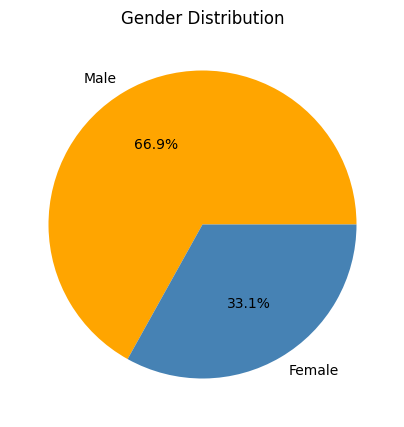

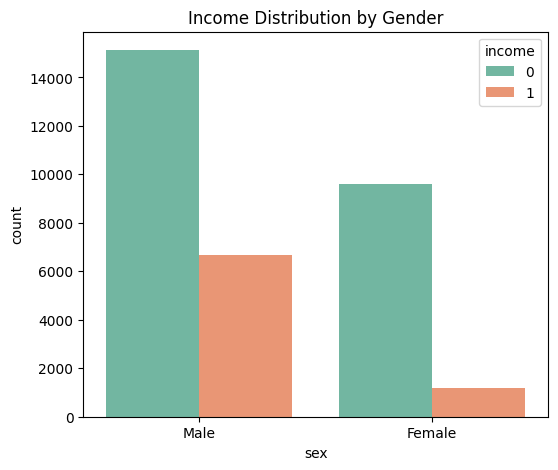

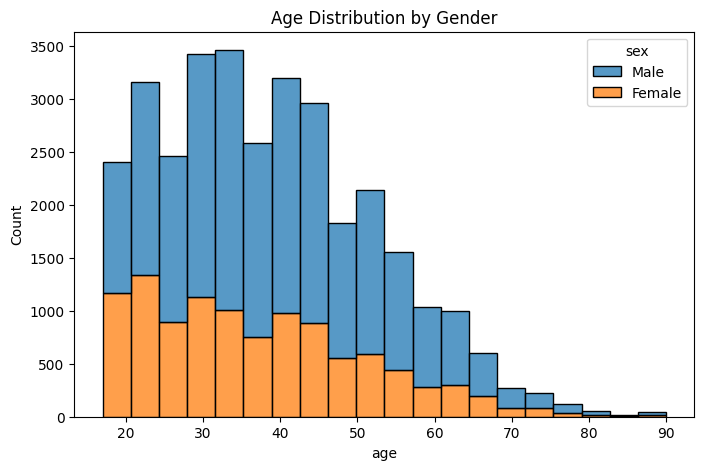

/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


AttributeError: 'BinaryLabelDatasetMetric' object has no attribute 'num_pos_neg'

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# -------------------------------
# 1. Load Adult dataset
# -------------------------------
url_adult = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
cols_adult = [
    'age','workclass','fnlwgt','education','education_num','marital_status',
    'occupation','relationship','race','sex','capital_gain','capital_loss',
    'hours_per_week','native_country','income'
]
df = pd.read_csv(url_adult, header=None, names=cols_adult, na_values=" ?", skipinitialspace=True)
df = df.dropna()
df['income'] = df['income'].map({'<=50K':0, '>50K':1})

# -------------------------------
# 2. Demographic breakdown
# -------------------------------
group_stats = df.groupby("sex").agg(
    Count=("sex","count"),
    PositiveRate=("income","mean"),
    AvgAge=("age","mean"),
    AvgHours=("hours_per_week","mean")
).reset_index()
group_stats["% of Total"] = 100 * group_stats["Count"] / len(df)
group_stats["% >50K"] = 100 * group_stats["PositiveRate"]

print("=== Demographic Breakdown ===")
print(group_stats)

# Pie chart
plt.figure(figsize=(5,5))
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', colors=["orange","steelblue"])
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()

# Stacked bar: income by sex
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="sex", hue="income", palette="Set2")
plt.title("Income Distribution by Gender")
plt.show()

# Histogram: age by gender & income
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="sex", multiple="stack", bins=20)
plt.title("Age Distribution by Gender")
plt.show()

# -------------------------------
# 3. Fairness Metrics
# -------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

dataset = StandardDataset(
    df_encoded,
    label_name="income",
    favorable_classes=[1],
    protected_attribute_names=["sex_Male"],
    privileged_classes=[[1]],
)

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)

metrics_table = {
    "Statistical Parity Difference": metric.mean_difference(),
    "Disparate Impact Ratio": metric.disparate_impact(),
    "Mean Difference": metric.mean_difference(),
    "Consistency Score": metric.consistency(),
    "Positive Class Discrepancy": metric.num_pos_neg()[0][1] - metric.num_pos_neg()[1][1],
    "Negative Class Discrepancy": metric.num_pos_neg()[0][0] - metric.num_pos_neg()[1][0]
}
print("\n=== Baseline Fairness Metrics ===")
print(pd.DataFrame.from_dict(metrics_table, orient="index", columns=["Value"]))

# -------------------------------
# 4. Threshold Guidelines
# -------------------------------
guidelines = pd.DataFrame({
    "Metric": [
        "Statistical Parity Difference",
        "Disparate Impact Ratio",
        "Mean Difference",
        "Consistency Score"
    ],
    "Ideal Value": [0, 1, 0, 1],
    "Fair Range": ["(-0.1, 0.1)", "(0.8, 1.2)", "(-0.1, 0.1)", "(0.9, 1.0)"],
    "Interpretation": [
        "Difference in positive outcome rates between groups",
        "Ratio of positive outcome rates between groups",
        "Difference in mean outcomes between groups",
        "How similar labels are for similar instances"
    ]
})
print("\n=== Fairness Threshold Guidelines ===")
print(guidelines)



=== Demographic Breakdown ===
      sex  Count  PositiveRate     AvgAge  % of Total  % > Good Credit
0  Female    310      0.648387  32.803226        31.0        64.838710
1    Male    690      0.723188  36.778261        69.0        72.318841


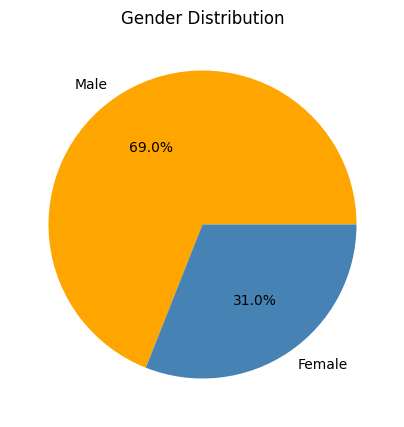

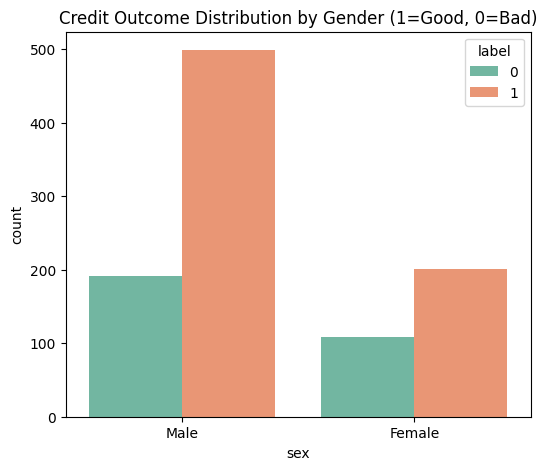

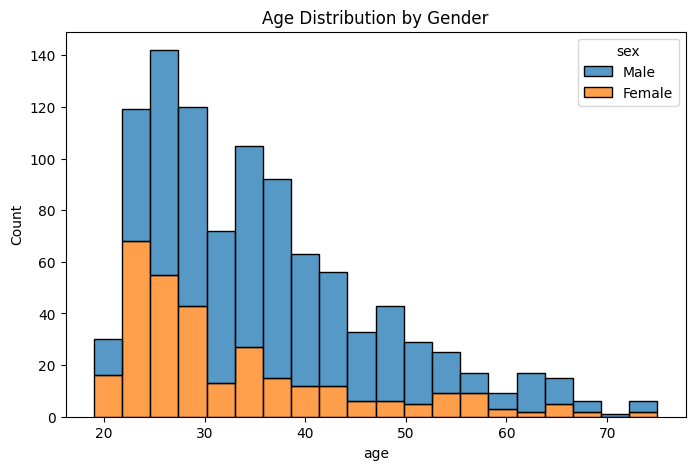

/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


AttributeError: 'BinaryLabelDatasetMetric' object has no attribute 'num_pos_neg'

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# -------------------------------
# 1. Load German Credit data
# -------------------------------
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
    'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker',
    'label'
]
df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['label'] = df['label'].map({1: 1, 2: 0})  # 1=good, 0=bad

# Map sex from personal_status
# A91, A93, A94 = male ; A92, A95 = female
df['sex'] = df['personal_status'].map(lambda x: 'Male' if x in ['A91','A93','A94'] else 'Female')

# -------------------------------
# 2. Demographic Breakdown
# -------------------------------
group_stats = df.groupby("sex").agg(
    Count=("sex","count"),
    PositiveRate=("label","mean"),
    AvgAge=("age","mean"),
).reset_index()

group_stats["% of Total"] = 100 * group_stats["Count"] / len(df)
group_stats["% > Good Credit"] = 100 * group_stats["PositiveRate"]

print("\n=== Demographic Breakdown ===")
print(group_stats)

# Pie chart
plt.figure(figsize=(5,5))
df['sex'].value_counts().plot.pie(autopct='%1.1f%%', colors=["orange","steelblue"])
plt.title("Gender Distribution")
plt.ylabel("")
plt.show()

# Stacked bar: credit label by sex
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="sex", hue="label", palette="Set2")
plt.title("Credit Outcome Distribution by Gender (1=Good, 0=Bad)")
plt.show()

# Histogram: age by gender & label
plt.figure(figsize=(8,5))
sns.histplot(data=df, x="age", hue="sex", multiple="stack", bins=20)
plt.title("Age Distribution by Gender")
plt.show()

# -------------------------------
# 3. Fairness Metrics
# -------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

dataset = StandardDataset(
    df_encoded,
    label_name="label",
    favorable_classes=[1],
    protected_attribute_names=["sex_Male"],
    privileged_classes=[[1]],  # Male=1
)

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)

metrics_table = {
    "Statistical Parity Difference": metric.mean_difference(),
    "Disparate Impact Ratio": metric.disparate_impact(),
    "Mean Difference": metric.mean_difference(),
    "Consistency Score": metric.consistency(),
    "Positive Class Discrepancy": metric.num_pos_neg()[0][1] - metric.num_pos_neg()[1][1],
    "Negative Class Discrepancy": metric.num_pos_neg()[0][0] - metric.num_pos_neg()[1][0]
}
print("\n=== Baseline Fairness Metrics ===")
print(pd.DataFrame.from_dict(metrics_table, orient="index", columns=["Value"]))

# -------------------------------
# 4. Threshold Guidelines
# -------------------------------
guidelines = pd.DataFrame({
    "Metric": [
        "Statistical Parity Difference",
        "Disparate Impact Ratio",
        "Mean Difference",
        "Consistency Score"
    ],
    "Ideal Value": [0, 1, 0, 1],
    "Fair Range": ["(-0.1, 0.1)", "(0.8, 1.2)", "(-0.1, 0.1)", "(0.9, 1.0)"],
    "Interpretation": [
        "Difference in positive outcome rates between groups",
        "Ratio of positive outcome rates between groups",
        "Difference in mean outcomes between groups",
        "How similar labels are for similar instances"
    ]
})
print("\n=== Fairness Threshold Guidelines ===")
print(guidelines)


,Gender,Count,% of Total,% > Good Credit,Average Age
0,Female,310,31.00%,64.84%,32.8 yrs
1,Male,690,69.00%,72.32%,36.8 yrs


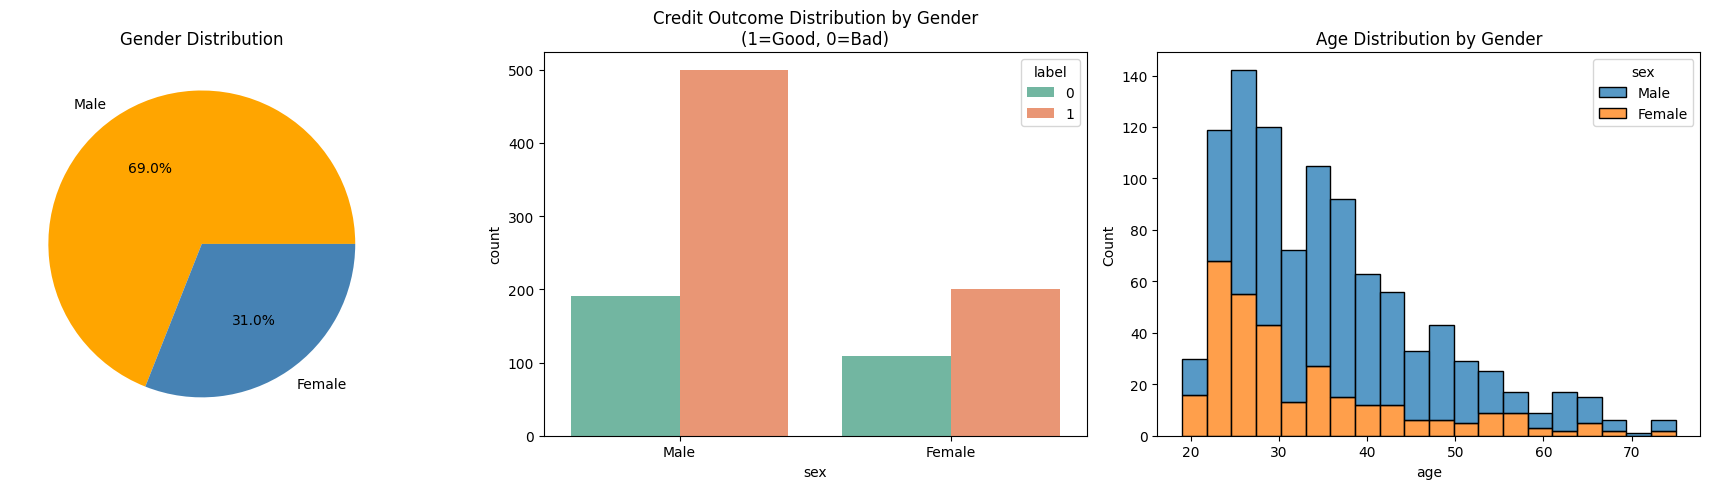

/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]


TypeError: unsupported format string passed to numpy.ndarray.__format__

,Metric,Ideal Value,Fair Range,Interpretation
0,Statistical Parity Difference,0,"(-0.1, 0.1)",Difference in positive outcome rates between g...
1,Disparate Impact Ratio,1,"(0.8, 1.2)",Ratio of positive outcome rates between groups
2,Mean Difference,0,"(-0.1, 0.1)",Difference in mean outcomes between groups
3,Consistency Score,1,"(0.9, 1.0)",How similar labels are for similar instances


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric

# -------------------------------
# 1. Load German Credit data
# -------------------------------
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = [
    'checking_status', 'duration', 'credit_history', 'purpose', 'credit_amount',
    'savings', 'employment', 'installment_rate', 'personal_status', 'other_debtors',
    'residence_since', 'property', 'age', 'other_installment_plans', 'housing',
    'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker',
    'label'
]
df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['label'] = df['label'].map({1: 1, 2: 0})  # 1=good, 0=bad

# Map sex from personal_status
df['sex'] = df['personal_status'].map(lambda x: 'Male' if x in ['A91','A93','A94'] else 'Female')

# -------------------------------
# 2. Demographic Breakdown
# -------------------------------
group_stats = df.groupby("sex").agg(
    Count=("sex","count"),
    PositiveRate=("label","mean"),
    AvgAge=("age","mean"),
).reset_index()

group_stats["% of Total"] = 100 * group_stats["Count"] / len(df)
group_stats["% > Good Credit"] = 100 * group_stats["PositiveRate"]

# Style demographic table
demo_table = group_stats[["sex","Count","% of Total","% > Good Credit","AvgAge"]]
demo_table = demo_table.rename(columns={"sex":"Gender","AvgAge":"Average Age"})
display(demo_table.style.format({
    "% of Total": "{:.2f}%",
    "% > Good Credit": "{:.2f}%",
    "Average Age": "{:.1f} yrs"
}))

# -------------------------------
# 3. Plots
# -------------------------------
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# Pie chart
df['sex'].value_counts().plot.pie(
    autopct='%1.1f%%', colors=["orange","steelblue"], ax=axes[0]
)
axes[0].set_title("Gender Distribution")
axes[0].set_ylabel("")

# Stacked bar
sns.countplot(data=df, x="sex", hue="label", palette="Set2", ax=axes[1])
axes[1].set_title("Credit Outcome Distribution by Gender\n(1=Good, 0=Bad)")

# Histogram
sns.histplot(data=df, x="age", hue="sex", multiple="stack", bins=20, ax=axes[2])
axes[2].set_title("Age Distribution by Gender")

plt.tight_layout()
plt.show()

# -------------------------------
# 4. Fairness Metrics
# -------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

dataset = StandardDataset(
    df_encoded,
    label_name="label",
    favorable_classes=[1],
    protected_attribute_names=["sex_Male"],
    privileged_classes=[[1]],  # Male=1
)

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)

# Compute discrepancies manually
priv_mask = df_encoded["sex_Male"] == 1
unpriv_mask = df_encoded["sex_Male"] == 0

priv_pos = df_encoded.loc[priv_mask, "label"].sum()
unpriv_pos = df_encoded.loc[unpriv_mask, "label"].sum()
priv_neg = len(df_encoded.loc[priv_mask]) - priv_pos
unpriv_neg = len(df_encoded.loc[unpriv_mask]) - unpriv_pos

positive_class_discrepancy = unpriv_pos - priv_pos
negative_class_discrepancy = unpriv_neg - priv_neg

metrics_table = pd.DataFrame({
    "Metric": [
        "Statistical Parity Difference",
        "Disparate Impact Ratio",
        "Mean Difference",
        "Consistency Score",
        "Positive Class Discrepancy",
        "Negative Class Discrepancy"
    ],
    "Value": [
        metric.mean_difference(),
        metric.disparate_impact(),
        metric.mean_difference(),
        metric.consistency(),
        positive_class_discrepancy,
        negative_class_discrepancy
    ]
})

# Style metrics table (red/green coloring)
metrics_table_styled = metrics_table.style.background_gradient(
    subset=["Value"], cmap="RdYlGn", low=0, high=0
).format({"Value":"{:.4f}"})
display(metrics_table_styled)

# -------------------------------
# 5. Fairness Threshold Guidelines
# -------------------------------
guidelines = pd.DataFrame({
    "Metric": [
        "Statistical Parity Difference",
        "Disparate Impact Ratio",
        "Mean Difference",
        "Consistency Score"
    ],
    "Ideal Value": [0, 1, 0, 1],
    "Fair Range": ["(-0.1, 0.1)", "(0.8, 1.2)", "(-0.1, 0.1)", "(0.9, 1.0)"],
    "Interpretation": [
        "Difference in positive outcome rates between groups",
        "Ratio of positive outcome rates between groups",
        "Difference in mean outcomes between groups",
        "How similar labels are for similar instances"
    ]
})
display(guidelines)


In [15]:
# -------------------------------
# 4. Fairness Metrics
# -------------------------------
df_encoded = pd.get_dummies(df, drop_first=True)

dataset = StandardDataset(
    df_encoded,
    label_name="label",
    favorable_classes=[1],
    protected_attribute_names=["sex_Male"],
    privileged_classes=[[1]],  # Male=1
)

metric = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)

# Compute discrepancies manually
priv_mask = df_encoded["sex_Male"] == 1
unpriv_mask = df_encoded["sex_Male"] == 0

priv_pos = df_encoded.loc[priv_mask, "label"].sum()
unpriv_pos = df_encoded.loc[unpriv_mask, "label"].sum()
priv_neg = len(df_encoded.loc[priv_mask]) - priv_pos
unpriv_neg = len(df_encoded.loc[unpriv_mask]) - unpriv_pos

positive_class_discrepancy = int(unpriv_pos - priv_pos)
negative_class_discrepancy = int(unpriv_neg - priv_neg)

# Safely cast to float
metrics_table = pd.DataFrame({
    "Metric": [
        "Statistical Parity Difference",
        "Disparate Impact Ratio",
        "Mean Difference",
        "Consistency Score",
        "Positive Class Discrepancy",
        "Negative Class Discrepancy"
    ],
    "Value": [
        float(np.asarray(metric.mean_difference())),
        float(np.asarray(metric.disparate_impact())),
        float(np.asarray(metric.mean_difference())),
        float(np.asarray(metric.consistency())),
        positive_class_discrepancy,
        negative_class_discrepancy
    ]
})

# Style metrics table (red/green coloring)
metrics_table_styled = metrics_table.style.background_gradient(
    subset=["Value"], cmap="RdYlGn", low=0, high=0
).format({"Value":"{:.4f}"}, subset=["Value"])
display(metrics_table_styled)


/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]
/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/3396788095.py:46: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(np.asarray(metric.consistency())),


,Metric,Value
0,Statistical Parity Difference,-0.0748
1,Disparate Impact Ratio,0.8966
2,Mean Difference,-0.0748
3,Consistency Score,0.6810
4,Positive Class Discrepancy,-298.0000
5,Negative Class Discrepancy,-82.0000



=== Bias Reduction Summary ===


/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:122: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[priv, attr] = privileged_values[0]
/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/2765423063.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "Consistency Score": float(np.asarray(metric.consistency())),
/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/2765423063.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this opera

,Metric,Before Mitigation,After Mitigation,Absolute Change,% Change
0,Statistical Parity Difference,-0.0748,-0.0000,0.0748,-100.00%
1,Disparate Impact Ratio,0.8966,1.0000,0.1034,11.54%
2,Mean Difference,-0.0748,-0.0000,0.0748,-100.00%
3,Consistency Score,0.6810,0.6810,0.0000,0.00%
4,Positive Class Discrepancy,-298.0000,-298.0000,0.0000,-0.00%
5,Negative Class Discrepancy,-82.0000,-82.0000,0.0000,-0.00%


/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/2765423063.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics_before.keys())[:3], y=list(metrics_before.values())[:3], palette="Set2")


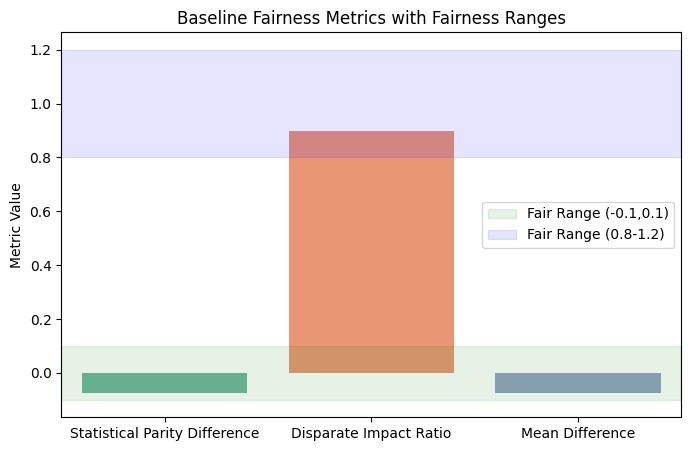

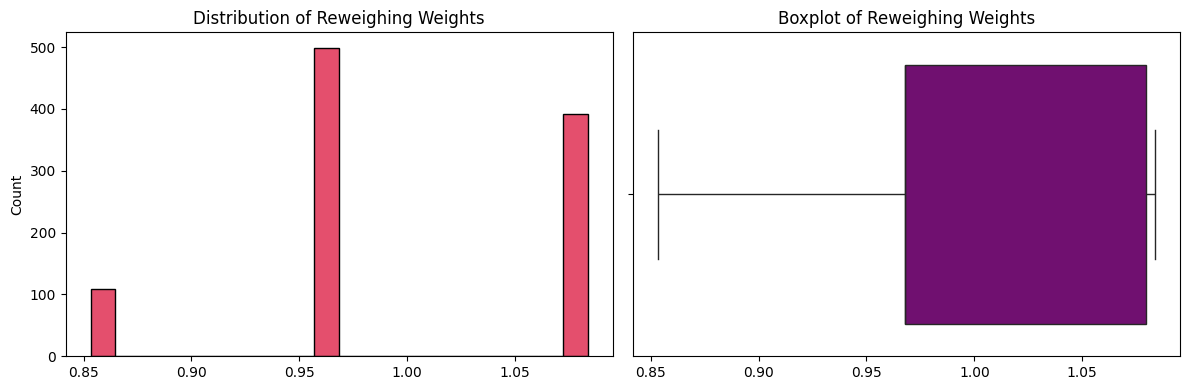


=== Reweighing Weight Statistics ===


,Statistic,Value
0,Minimum,0.8532
1,Maximum,1.0838
2,Mean,1.0000
3,Median,0.9679
4,Standard Deviation,0.0740
5,Q1 (25th percentile),0.9679
6,Q3 (75th percentile),1.0796


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# -------------------------------
# 1. Load German Credit Data
# -------------------------------
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = [
    'checking_status','duration','credit_history','purpose','credit_amount',
    'savings','employment','installment_rate','personal_status','other_debtors',
    'residence_since','property','age','other_installment_plans','housing',
    'existing_credits','job','num_dependents','own_telephone','foreign_worker',
    'label'
]
df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['label'] = df['label'].map({1: 1, 2: 0})  # 1=good, 0=bad
df['sex'] = df['personal_status'].map(lambda x: 'Male' if x in ['A91','A93','A94'] else 'Female')

# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

# -------------------------------
# 2. Build AIF360 Dataset
# -------------------------------
dataset = StandardDataset(
    df_encoded,
    label_name="label",
    favorable_classes=[1],
    protected_attribute_names=["sex_Male"],
    privileged_classes=[[1]],  # Male=1
)

# -------------------------------
# 3. Metrics BEFORE Mitigation
# -------------------------------
metric_before = BinaryLabelDatasetMetric(
    dataset,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)

def compute_metrics(metric, df_encoded):
    priv_mask = df_encoded["sex_Male"] == 1
    unpriv_mask = df_encoded["sex_Male"] == 0

    priv_pos = df_encoded.loc[priv_mask, "label"].sum()
    unpriv_pos = df_encoded.loc[unpriv_mask, "label"].sum()
    priv_neg = len(df_encoded.loc[priv_mask]) - priv_pos
    unpriv_neg = len(df_encoded.loc[unpriv_mask]) - unpriv_pos

    return {
        "Statistical Parity Difference": float(np.asarray(metric.mean_difference())),
        "Disparate Impact Ratio": float(np.asarray(metric.disparate_impact())),
        "Mean Difference": float(np.asarray(metric.mean_difference())),
        "Consistency Score": float(np.asarray(metric.consistency())),
        "Positive Class Discrepancy": int(unpriv_pos - priv_pos),
        "Negative Class Discrepancy": int(unpriv_neg - priv_neg)
    }

metrics_before = compute_metrics(metric_before, df_encoded)

# -------------------------------
# 4. Apply Reweighing
# -------------------------------
RW = Reweighing(
    unprivileged_groups=[{'sex_Male': 0}],
    privileged_groups=[{'sex_Male': 1}]
)
dataset_transf = RW.fit_transform(dataset)

# Collect weights for distribution plots
weights = dataset_transf.instance_weights

# -------------------------------
# 5. Metrics AFTER Mitigation
# -------------------------------
df_encoded_rw = df_encoded.copy()
metric_after = BinaryLabelDatasetMetric(
    dataset_transf,
    privileged_groups=[{'sex_Male': 1}],
    unprivileged_groups=[{'sex_Male': 0}]
)
metrics_after = compute_metrics(metric_after, df_encoded_rw)

# -------------------------------
# 6. Comparison Table
# -------------------------------
metrics_compare = pd.DataFrame({
    "Metric": metrics_before.keys(),
    "Before Mitigation": metrics_before.values(),
    "After Mitigation": metrics_after.values()
})
metrics_compare["Absolute Change"] = metrics_compare["After Mitigation"] - metrics_compare["Before Mitigation"]
metrics_compare["% Change"] = (metrics_compare["Absolute Change"] / metrics_compare["Before Mitigation"].replace(0, np.nan)) * 100

print("\n=== Bias Reduction Summary ===")
display(metrics_compare.style.background_gradient(
    subset=["Absolute Change","% Change"], cmap="RdYlGn"
).format({"Before Mitigation":"{:.4f}","After Mitigation":"{:.4f}","Absolute Change":"{:.4f}","% Change":"{:.2f}%"}))

# -------------------------------
# 7. Visualization
# -------------------------------

# (a) Baseline fairness metrics bar chart
plt.figure(figsize=(8,5))
sns.barplot(x=list(metrics_before.keys())[:3], y=list(metrics_before.values())[:3], palette="Set2")
plt.axhspan(-0.1,0.1, color="green", alpha=0.1, label="Fair Range (-0.1,0.1)")
plt.axhspan(0.8,1.2, color="blue", alpha=0.1, label="Fair Range (0.8-1.2)")
plt.title("Baseline Fairness Metrics with Fairness Ranges")
plt.ylabel("Metric Value")
plt.legend()
plt.show()

# (b) Reweighing weights distribution
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.histplot(weights, bins=20, ax=ax[0], color="crimson")
ax[0].set_title("Distribution of Reweighing Weights")
sns.boxplot(x=weights, ax=ax[1], color="purple")
ax[1].set_title("Boxplot of Reweighing Weights")
plt.tight_layout()
plt.show()

# (c) Detailed Weight Statistics
weight_stats = pd.DataFrame({
    "Statistic": ["Minimum","Maximum","Mean","Median","Standard Deviation","Q1 (25th percentile)","Q3 (75th percentile)"],
    "Value": [
        np.min(weights),
        np.max(weights),
        np.mean(weights),
        np.median(weights),
        np.std(weights),
        np.percentile(weights,25),
        np.percentile(weights,75)
    ]
})

print("\n=== Reweighing Weight Statistics ===")
display(weight_stats.style.background_gradient(cmap="Purples").format({"Value":"{:.4f}"}))


In [18]:
from sklearn.metrics import balanced_accuracy_score


In [23]:
from sklearn.metrics import balanced_accuracy_score

def collect_metrics(metric, y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Disparate Impact Ratio": metric.disparate_impact(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "False Positive Rate Difference": metric.false_positive_rate_difference(),
        "True Positive Rate Difference": metric.true_positive_rate_difference(),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred)   # ✅ sklearn fix
    }


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tempfile, os
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet

# -------------------------------
# Collect metrics into DataFrame
# -------------------------------
def collect_metrics(metric, y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Disparate Impact Ratio": metric.disparate_impact(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "False Positive Rate Difference": metric.false_positive_rate_difference(),
        "True Positive Rate Difference": metric.true_positive_rate_difference(),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred)
    }

metrics_orig = collect_metrics(metric_orig, y_test, y_pred)
metrics_rw   = collect_metrics(metric_rw, y_test, y_pred_rw)

metrics_compare = pd.DataFrame({
    "Metric": list(metrics_orig.keys()),
    "Original Model": list(metrics_orig.values()),
    "Mitigated Model": list(metrics_rw.values())
})
metrics_compare["Difference"] = metrics_compare["Mitigated Model"] - metrics_compare["Original Model"]

# Force floats
for col in ["Original Model", "Mitigated Model", "Difference"]:
    metrics_compare[col] = pd.to_numeric(metrics_compare[col], errors="coerce").astype(float)

# -------------------------------
# Create a writable temp directory
# -------------------------------
out_dir = tempfile.mkdtemp()
print("📂 Saving outputs in:", out_dir)

# -------------------------------
# Confusion Matrices
# -------------------------------
def plot_confusion(y_true, y_pred, title, filename):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.savefig(filename, bbox_inches="tight")
    plt.close()

plot_confusion(y_test, y_pred, "Original Model", os.path.join(out_dir, "cm_orig.png"))
plot_confusion(y_test, y_pred_rw, "Mitigated Model", os.path.join(out_dir, "cm_rw.png"))

# -------------------------------
# Fairness–Accuracy Tradeoff
# -------------------------------
tradeoff_path = os.path.join(out_dir, "fairness_tradeoff.png")
plt.figure(figsize=(6,5))
plt.scatter(abs(metrics_orig["Statistical Parity Difference"]), metrics_orig["Accuracy"], 
            label="Original Model", s=120, c="blue")
plt.scatter(abs(metrics_rw["Statistical Parity Difference"]), metrics_rw["Accuracy"], 
            label="Mitigated Model", s=120, c="orange")
plt.xlabel("|Statistical Parity Difference| (Lower = Fairer)")
plt.ylabel("Accuracy (Higher = Better)")
plt.title("Fairness–Accuracy Tradeoff")
plt.legend()
plt.savefig(tradeoff_path, bbox_inches="tight")
plt.close()

# -------------------------------
# Radar Chart
# -------------------------------
radar_path = os.path.join(out_dir, "radar_chart.png")
metrics_for_radar = [
    "Accuracy", "F1 Score", "Balanced Accuracy",
    "Statistical Parity Difference", "Equal Opportunity Difference",
    "Average Odds Difference", "False Positive Rate Difference", "True Positive Rate Difference"
]

orig_vals = [metrics_orig[m] for m in metrics_for_radar]
rw_vals   = [metrics_rw[m] for m in metrics_for_radar]

def normalize(values):
    arr = np.array(values, dtype=float)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

orig_norm = normalize(orig_vals)
rw_norm   = normalize(rw_vals)

angles = np.linspace(0, 2*np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))
ax.plot(angles, np.concatenate([orig_norm, [orig_norm[0]]]), "o-", linewidth=2, label="Original", color="blue")
ax.fill(angles, np.concatenate([orig_norm, [orig_norm[0]]]), alpha=0.25, color="blue")
ax.plot(angles, np.concatenate([rw_norm, [rw_norm[0]]]), "o-", linewidth=2, label="Mitigated", color="orange")
ax.fill(angles, np.concatenate([rw_norm, [rw_norm[0]]]), alpha=0.25, color="orange")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=9)
plt.title("Normalized Model Performance Comparison", fontsize=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.savefig(radar_path, bbox_inches="tight")
plt.close()

# -------------------------------
# PDF Export
# -------------------------------
pdf_path = os.path.join(out_dir, "German_Fairness_Report.pdf")
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("German Dataset Fairness & Performance Report", styles["Title"]))
elements.append(Spacer(1, 12))

# Add table
table_data = [metrics_compare.columns.tolist()] + metrics_compare.round(4).values.tolist()
t = Table(table_data)
t.setStyle(TableStyle([
    ("BACKGROUND", (0,0), (-1,0), colors.lightgrey),
    ("ALIGN", (0,0), (-1,-1), "CENTER"),
    ("GRID", (0,0), (-1,-1), 0.5, colors.grey)
]))
elements.append(t)
elements.append(Spacer(1, 20))

# Add plots
for img_file in ["cm_orig.png", "cm_rw.png", "fairness_tradeoff.png", "radar_chart.png"]:
    img_path = os.path.join(out_dir, img_file)
    if os.path.exists(img_path):
        elements.append(Image(img_path, width=400, height=400))
        elements.append(Spacer(1, 20))

doc.build(elements)
print("✅ PDF Report saved at:", pdf_path)


📂 Saving outputs in: /var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/tmp391zez5v
✅ PDF Report saved at: /var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/tmp391zez5v/German_Fairness_Report.pdf



=== Model Performance & Fairness Comparison ===


,Metric,Original Model,Mitigated Model,Difference
0,Accuracy,0.7600,0.7533,-0.0067
1,F1 Score,0.8386,0.8356,-0.0030
2,Statistical Parity Difference,-0.0051,0.0476,0.0527
3,Disparate Impact Ratio,0.9936,1.0595,0.0659
4,Equal Opportunity Difference,-0.0269,0.0106,0.0375
5,Average Odds Difference,0.0481,0.1053,0.0572
6,False Positive Rate Difference,0.1232,0.2001,0.0769
7,True Positive Rate Difference,-0.0269,0.0106,0.0375
8,Balanced Accuracy,0.6719,0.6585,-0.0134


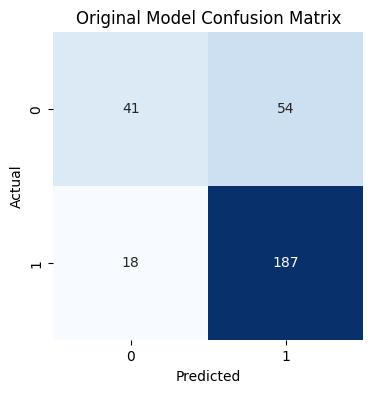

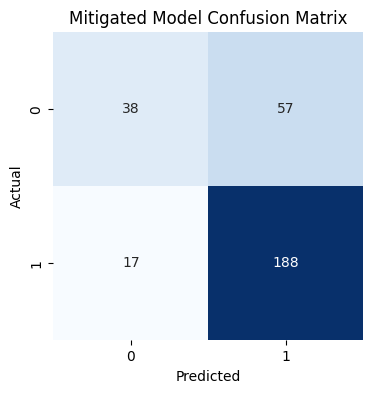

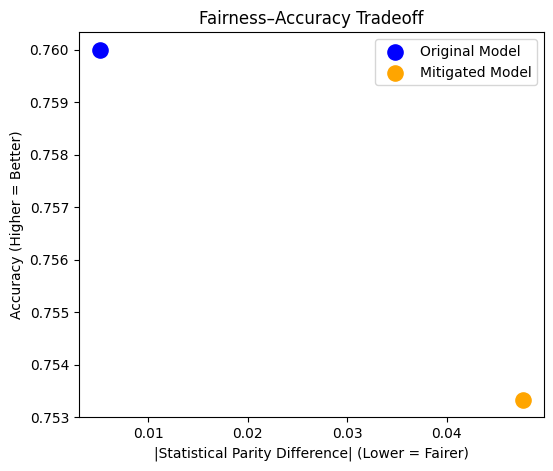

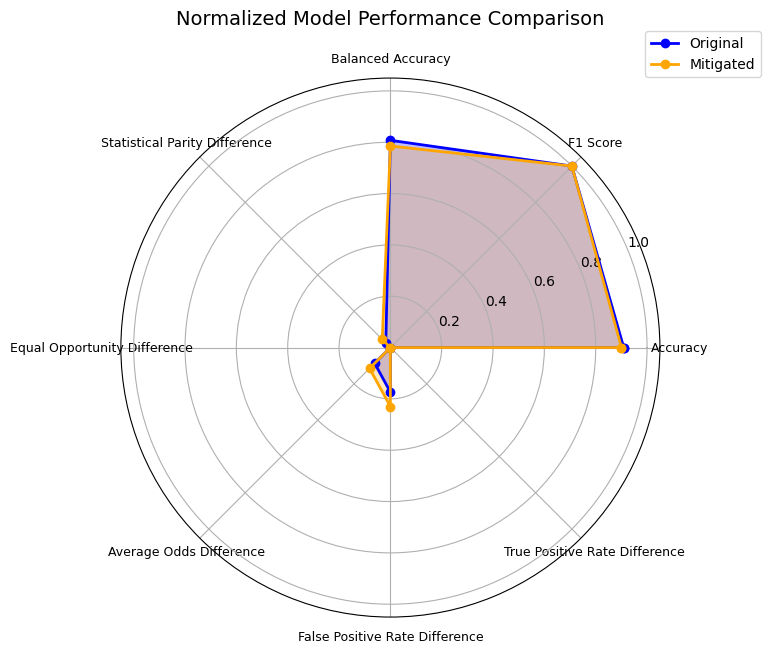

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score

# -------------------------------
# Collect metrics into DataFrame
# -------------------------------
def collect_metrics(metric, y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "Statistical Parity Difference": metric.statistical_parity_difference(),
        "Disparate Impact Ratio": metric.disparate_impact(),
        "Equal Opportunity Difference": metric.equal_opportunity_difference(),
        "Average Odds Difference": metric.average_odds_difference(),
        "False Positive Rate Difference": metric.false_positive_rate_difference(),
        "True Positive Rate Difference": metric.true_positive_rate_difference(),
        "Balanced Accuracy": balanced_accuracy_score(y_true, y_pred)
    }

metrics_orig = collect_metrics(metric_orig, y_test, y_pred)
metrics_rw   = collect_metrics(metric_rw, y_test, y_pred_rw)

metrics_compare = pd.DataFrame({
    "Metric": list(metrics_orig.keys()),
    "Original Model": list(metrics_orig.values()),
    "Mitigated Model": list(metrics_rw.values())
})
metrics_compare["Difference"] = metrics_compare["Mitigated Model"] - metrics_compare["Original Model"]

# Force numeric columns
for col in ["Original Model", "Mitigated Model", "Difference"]:
    metrics_compare[col] = pd.to_numeric(metrics_compare[col], errors="coerce").astype(float)

# -------------------------------
# Show metrics table
# -------------------------------
print("\n=== Model Performance & Fairness Comparison ===")
display(
    metrics_compare.style
    .format("{:.4f}", subset=["Original Model","Mitigated Model","Difference"])
    .background_gradient(cmap="RdYlGn", subset=["Difference"])
)

# -------------------------------
# Confusion Matrices
# -------------------------------
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_test, y_pred, "Original Model Confusion Matrix")
plot_confusion(y_test, y_pred_rw, "Mitigated Model Confusion Matrix")

# -------------------------------
# Fairness–Accuracy Tradeoff
# -------------------------------
plt.figure(figsize=(6,5))
plt.scatter(abs(metrics_orig["Statistical Parity Difference"]), metrics_orig["Accuracy"], 
            label="Original Model", s=120, c="blue")
plt.scatter(abs(metrics_rw["Statistical Parity Difference"]), metrics_rw["Accuracy"], 
            label="Mitigated Model", s=120, c="orange")
plt.xlabel("|Statistical Parity Difference| (Lower = Fairer)")
plt.ylabel("Accuracy (Higher = Better)")
plt.title("Fairness–Accuracy Tradeoff")
plt.legend()
plt.show()

# -------------------------------
# Radar Chart (Normalized Metrics)
# -------------------------------
metrics_for_radar = [
    "Accuracy", "F1 Score", "Balanced Accuracy",
    "Statistical Parity Difference", "Equal Opportunity Difference",
    "Average Odds Difference", "False Positive Rate Difference", "True Positive Rate Difference"
]

orig_vals = [metrics_orig[m] for m in metrics_for_radar]
rw_vals   = [metrics_rw[m] for m in metrics_for_radar]

def normalize(values):
    arr = np.array(values, dtype=float)
    return (arr - arr.min()) / (arr.max() - arr.min() + 1e-8)

orig_norm = normalize(orig_vals)
rw_norm   = normalize(rw_vals)

angles = np.linspace(0, 2*np.pi, len(metrics_for_radar), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))
ax.plot(angles, np.concatenate([orig_norm, [orig_norm[0]]]), "o-", linewidth=2, label="Original", color="blue")
ax.fill(angles, np.concatenate([orig_norm, [orig_norm[0]]]), alpha=0.25, color="blue")
ax.plot(angles, np.concatenate([rw_norm, [rw_norm[0]]]), "o-", linewidth=2, label="Mitigated", color="orange")
ax.fill(angles, np.concatenate([rw_norm, [rw_norm[0]]]), alpha=0.25, color="orange")
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_for_radar, fontsize=9)
plt.title("Normalized Model Performance Comparison", fontsize=14, pad=20)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


In [ ]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, confusion_matrix
from aif360.datasets import BankDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# =============================================================================
# INITIALIZATION AND SETUP
# =============================================================================
display(HTML("<h1 style='text-align:center; color:#1f77b4;'>AI FAIRNESS 360: BANK MARKETING ANALYSIS</h1>"))
display(HTML("<h3 style='text-align:center;'>Comprehensive Bias Mitigation Analysis with Enhanced Visualizations</h3>"))

# Custom styling functions
def color_negative_positive(val):
    if isinstance(val, (int, float)):
        color = 'red' if val < 0 else 'green' if val > 0 else 'black'
        return f'color: {color}; font-weight: bold'
    return ""

def highlight_metrics(s):
    metrics = ['Statistical Parity Difference', 'Equal Opportunity Difference', 'Average Odds Difference']
    is_metric = s.index.isin(metrics)
    return ['background-color: #fffacd' if v else "" for v in is_metric]

def format_percent(x):
    return f"{float(x):.2%}"

# Visualization setup
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# =============================================================================
# STEP 1: DATA LOADING AND EXPLORATION
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 1: BANK DATASET LOADING AND EXPLORATORY ANALYSIS</h2>"))


try:
    # Load Bank Marketing dataset with enhanced parameters
    dataset = BankDataset()

    # Convert to dataframe for comprehensive analysis
    df, _ = dataset.convert_to_dataframe()
    df['subscription'] = df['y'].apply(lambda x: 'Subscribed' if x == 1 else 'Not Subscribed')
    
    # Age groups - the protected attribute is age with privileged: 25 <= age < 60
    def categorize_age(age_binary):
        return 'Working Age (25-59)' if age_binary == 1 else 'Young/Senior (<25 or >=60)'
    
    df['age_group'] = df['age'].apply(categorize_age)

    # Enhanced dataset statistics
    stats_data = {
        'Description': [
            'Total samples',
            'Number of features',
            'Protected attribute',
            'Target variable',
            'Positive class (Subscribed)',
            'Negative class (Not Subscribed)'
        ],
        'Value': [
            len(df),
            len(df.columns) - 2,  # Exclude derived columns
            'age (binary: working age vs young/senior)',
            'subscription to bank term deposit',
            df['subscription'].value_counts()['Subscribed'],
            df['subscription'].value_counts()['Not Subscribed']
        ]
    }

    stats_df = pd.DataFrame(stats_data)
    display(stats_df.style.set_caption("Bank Marketing Dataset Summary")
            .hide(axis='index')
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

    # Comprehensive demographic analysis
    demo_stats = pd.DataFrame({
        'Count': df['age_group'].value_counts(),
        '% of Total': df['age_group'].value_counts(normalize=True) * 100,
        '% Subscribed': df.groupby('age_group')['subscription'].apply(lambda x: (x == 'Subscribed').mean() * 100)
    })

    display(demo_stats.style.format({
        '% of Total': '{:.2f}%',
        '% Subscribed': '{:.2f}%'
    }).set_caption("Detailed Age Group Breakdown")
            .background_gradient(cmap='Blues', subset=['Count'])
            .set_properties(**{'text-align': 'center'}))

    # Enhanced visualizations
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Age distribution
    age_counts = df['age_group'].value_counts()
    wedges, texts, autotexts = ax1.pie(age_counts, labels=age_counts.index,
                                        autopct='%1.1f%%', colors=colors[:2],
                                        startangle=90, textprops={'fontsize': 12})
    ax1.set_title('Age Group Distribution', fontsize=14, pad=20)

    # Subscription distribution by age group
    subscription_by_age = pd.crosstab(df['age_group'], df['subscription'])
    subscription_by_age.plot(kind='bar', stacked=True, ax=ax2,
                            color=['#d62728', '#2ca02c'], width=0.6)
    ax2.set_title('Subscription Distribution by Age Group', fontsize=14, pad=20)
    ax2.set_ylabel('Count', fontsize=12)
    ax2.set_xlabel('Age Group', fontsize=12)
    ax2.legend(title='Subscription', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)

    # Job distribution for subscribed customers
    job_subscription = df[df['subscription'] == 'Subscribed']['job'].value_counts().head(8)
    ax3.barh(job_subscription.index, job_subscription.values, color='#2ca02c')
    ax3.set_title('Top Jobs Among Subscribed Customers', fontsize=14, pad=20)
    ax3.set_xlabel('Number of Subscriptions', fontsize=12)

    plt.tight_layout()
    plt.show()

    # Define privileged/unprivileged groups
    # Privileged: Working age (25-59), Unprivileged: Young/Senior (<25 or >=60)
    privileged_groups = [{'age': 1}]  # Working age (25-59)
    unprivileged_groups = [{'age': 0}]  # Young/Senior (<25 or >=60)

    # Split dataset with detailed reporting
    dataset_train, dataset_test = dataset.split([0.7], shuffle=True, seed=42)

    split_stats = pd.DataFrame({
        '': ['Count', 'Percentage'],
        'Training Set': [
            f"{dataset_train.features.shape[0]:,}",
            f"{dataset_train.features.shape[0]/len(df):.1%}"
        ],
        'Test Set': [
            f"{dataset_test.features.shape[0]:,}",
            f"{dataset_test.features.shape[0]/len(df):.1%}"
        ]
    }).set_index('')

    display(split_stats.style.set_caption("Dataset Split Information")
            .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

except Exception as e:
    display(HTML(f"<div style='color:red; font-weight:bold;'>ERROR LOADING DATASET: {str(e)}</div>"))
    raise

# =============================================================================
# STEP 2: BASELINE BIAS QUANTIFICATION
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 2: BASELINE BIAS QUANTIFICATION</h2>"))

# Comprehensive bias metrics
metric_train = BinaryLabelDatasetMetric(
    dataset_train,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

original_metrics = {
    'Statistical Parity Difference': float(metric_train.statistical_parity_difference()),
    'Disparate Impact Ratio': float(metric_train.disparate_impact()),
    'Mean Difference': float(metric_train.mean_difference()),
    'Consistency Score': float(metric_train.consistency()),
    'Positive Class Discrepancy': float(metric_train.difference(metric_train.num_positives)),
    'Negative Class Discrepancy': float(metric_train.difference(metric_train.num_negatives))
}

# Create styled metrics table
metrics_df = pd.DataFrame.from_dict(original_metrics, orient='index', columns=['Value'])
metrics_df.index.name = 'Metric'

styled_metrics = metrics_df.style.format("{:.4f}") \
    .set_caption("Comprehensive Baseline Fairness Metrics") \
    .map(color_negative_positive) \
    .apply(highlight_metrics) \
    .background_gradient(cmap='YlOrBr') \
    .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled_metrics)

# Fairness thresholds with explanations
thresholds = {
    'Metric': [
        'Statistical Parity Difference',
        'Disparate Impact Ratio',
        'Mean Difference',
        'Consistency Score'
    ],
    'Ideal Value': [0.0, 1.0, 0.0, 1.0],
    'Fair Range': [
        '(-0.1, 0.1)',
        '(0.8, 1.2)',
        '(-0.1, 0.1)',
        '(0.9, 1.0]'
    ],
    'Interpretation': [
        'Difference in positive outcome rates between age groups',
        'Ratio of positive outcome rates between age groups',
        'Difference in mean outcomes between age groups',
        'How similar labels are for similar instances'
    ]
}

display(pd.DataFrame(thresholds).style.set_caption("Fairness Threshold Guidelines with Interpretations")
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]},
                           {'selector': 'td', 'props': [('max-width', '300px')]}]))

# Enhanced visualization
fig, ax = plt.subplots(figsize=(12, 7))
metrics_to_plot = ['Statistical Parity Difference', 'Disparate Impact Ratio', 'Mean Difference']
values = [original_metrics[m] for m in metrics_to_plot]

bars = ax.bar(metrics_to_plot, values, color=colors[:3], width=0.6)

# Add reference lines and annotations
ax.axhline(0, color='black', linewidth=0.8)
ax.axhspan(-0.1, 0.1, alpha=0.1, color='green')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}',
            ha='center', va='bottom', fontsize=12)

ax.set_title('Baseline Fairness Metrics with Fairness Ranges', fontsize=16, pad=20)
ax.set_ylabel('Metric Value', fontsize=14)
ax.set_xticklabels(metrics_to_plot, rotation=15, ha='right', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 3: REWEIGHING MITIGATION
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 3: APPLYING REWEIGHING MITIGATION</h2>"))
display(HTML("<div style='margin-bottom:15px;'>"
             "<h4>Reweighing Algorithm Overview:</h4>"
             "<ul>"
             "<li>Assigns weights to instances to compensate for age-based bias</li>"
             "<li>Increases weight of underrepresented (young/senior + subscribed) instances</li>"
             "<li>Decreases weight of overrepresented (working-age + subscribed) instances</li>"
             "<li>Preserves all features while adjusting influence during training</li>"
             "</ul>"
             "</div>"))

# Apply reweighing
RW = Reweighing(
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)
dataset_train_transf = RW.fit_transform(dataset_train)

# Detailed weight analysis
weights = dataset_train_transf.instance_weights
weight_stats = {
    'Statistic': ['Minimum', 'Maximum', 'Mean', 'Median', 'Standard Deviation',
                  'Q1 (25th percentile)', 'Q3 (75th percentile)'],
    'Value': [
        np.min(weights),
        np.max(weights),
        np.mean(weights),
        np.median(weights),
        np.std(weights),
        np.percentile(weights, 25),
        np.percentile(weights, 75)
    ]
}

display(pd.DataFrame(weight_stats).style.format({'Value': '{:.4f}'})
        .set_caption("Detailed Reweighing Weight Statistics")
        .background_gradient(cmap='Purples', subset=['Value'])
        .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

# Weight distribution visualization
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.hist(weights, bins=50, color=colors[3], edgecolor='black')
plt.title('Distribution of Reweighing Weights', fontsize=14, pad=20)
plt.xlabel('Weight Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2)
plt.boxplot(weights, vert=False, patch_artist=True,
            boxprops=dict(facecolor=colors[4]),
            medianprops=dict(color='black'))
plt.title('Boxplot of Reweighing Weights', fontsize=14, pad=20)
plt.xlabel('Weight Value', fontsize=12)
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# =============================================================================
# STEP 4: POST-MITIGATION ANALYSIS
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 4: POST-MITIGATION ANALYSIS</h2>"))

metric_train_transf = BinaryLabelDatasetMetric(
    dataset_train_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups)

# Convert all metrics to float explicitly
mitigated_metrics = {
    'Statistical Parity Difference': float(metric_train_transf.statistical_parity_difference()),
    'Disparate Impact Ratio': float(metric_train_transf.disparate_impact()),
    'Mean Difference': float(metric_train_transf.mean_difference()),
    'Consistency Score': float(metric_train_transf.consistency()),
    'Positive Class Discrepancy': float(metric_train_transf.difference(metric_train_transf.num_positives)),
    'Negative Class Discrepancy': float(metric_train_transf.difference(metric_train_transf.num_negatives))
}

# Ensure original_metrics are also floats
original_metrics = {k: float(v) for k, v in original_metrics.items()}

# Create comprehensive comparison table
comparison = pd.DataFrame({
    'Before Mitigation': original_metrics,
    'After Mitigation': mitigated_metrics,
    'Absolute Change': {k: mitigated_metrics[k] - original_metrics[k] for k in original_metrics},
    '% Change': {k: (mitigated_metrics[k] - original_metrics[k])/original_metrics[k]*100 
                    if original_metrics[k] != 0 else np.nan for k in original_metrics}
})

# Style the comparison table
styled_comparison = comparison.style.format({
    'Before Mitigation': '{:.4f}',
    'After Mitigation': '{:.4f}',
    'Absolute Change': '{:.4f}',
    '% Change': '{:.2f}%'
}).set_caption("Comprehensive Bias Reduction Summary") \
    .map(color_negative_positive, subset=['Absolute Change', '% Change']) \
    .background_gradient(cmap='RdYlGn', subset=['Before Mitigation', 'After Mitigation']) \
    .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled_comparison)

# Visual comparison
fig, ax = plt.subplots(figsize=(14, 7))
metrics_to_compare = ['Statistical Parity Difference', 'Disparate Impact Ratio', 'Mean Difference']
x = np.arange(len(metrics_to_compare))
width = 0.35

rects1 = ax.bar(x - width/2, [original_metrics[m] for m in metrics_to_compare],
                width, label='Before', color=colors[0])
rects2 = ax.bar(x + width/2, [mitigated_metrics[m] for m in metrics_to_compare],
                width, label='After', color=colors[1])

# Add reference lines and annotations
ax.axhline(0, color='black', linewidth=0.8)

# Add value labels
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

ax.set_title('Fairness Metric Comparison: Before vs After Reweighing', fontsize=16, pad=20)
ax.set_ylabel('Metric Value', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_to_compare, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 5: MODEL TRAINING AND EVALUATION
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 5: MODEL TRAINING AND FAIRNESS EVALUATION</h2>"))

# Data preparation
scaler = StandardScaler()
X_train = scaler.fit_transform(dataset_train.features)
y_train = dataset_train.labels.ravel()
X_test = scaler.transform(dataset_test.features)
y_test = dataset_test.labels.ravel()

# Model training with detailed logging
display(HTML("<h4 style='margin-bottom:10px;'>Training Process:</h4>"))
print("Training original model (no mitigation)...")
model_orig = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
model_orig.fit(X_train, y_train)

print("\nTraining model with reweighted data...")
X_train_transf = scaler.fit_transform(dataset_train_transf.features)
y_train_transf = dataset_train_transf.labels.ravel()
model_transf = LogisticRegression(max_iter=1000, random_state=42)
model_transf.fit(X_train_transf, y_train_transf, sample_weight=dataset_train_transf.instance_weights)

# Enhanced evaluation function
def evaluate_model(model, X, y, dataset, name):
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]
    
    # Calculate standard metrics
    f1 = f1_score(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    
    # AIF360 metrics
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred.reshape(-1, 1)
    metric = ClassificationMetric(
        dataset,
        dataset_pred,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
    
    # Comprehensive results
    results = {
        'Accuracy': metric.accuracy(),
        'F1 Score': f1,
        'Statistical Parity Difference': metric.statistical_parity_difference(),
        'Disparate Impact Ratio': metric.disparate_impact(),
        'Equal Opportunity Difference': metric.equal_opportunity_difference(),
        'Average Odds Difference': metric.average_odds_difference(),
        'False Positive Rate Difference': metric.false_positive_rate_difference(),
        'True Positive Rate Difference': metric.true_positive_rate_difference(),
        'Balanced Accuracy': (metric.true_positive_rate(privileged=True) +
                              metric.true_negative_rate(privileged=True) +
                              metric.true_positive_rate(privileged=False) +
                              metric.true_negative_rate(privileged=False)) / 4
    }
    
    # Confusion matrices by group
    cm_priv = {
        'TP': metric.num_true_positives(privileged=True),
        'FP': metric.num_false_positives(privileged=True),
        'TN': metric.num_true_negatives(privileged=True),
        'FN': metric.num_false_negatives(privileged=True),
    }
    cm_unpriv = {
        'TP': metric.num_true_positives(privileged=False),
        'FP': metric.num_false_positives(privileged=False),
        'TN': metric.num_true_negatives(privileged=False),
        'FN': metric.num_false_negatives(privileged=False),
    }
    
    return results, cm_priv, cm_unpriv, cm, y_prob

# Evaluate both models
display(HTML("<h4 style='margin-bottom:10px;'>Model Evaluation:</h4>"))
orig_results, cm_priv_orig, cm_unpriv_orig, cm_orig, y_prob_orig = evaluate_model(
    model_orig, X_test, y_test, dataset_test, "Original")
transf_results, cm_priv_transf, cm_unpriv_transf, cm_transf, y_prob_transf = evaluate_model(
    model_transf, X_test, y_test, dataset_test, "Mitigated")

# Results comparison
results_df = pd.DataFrame({
    'Original Model': orig_results,
    'Mitigated Model': transf_results,
    'Difference': {k: transf_results[k] - orig_results[k] for k in orig_results}
})

# Apply styling with improved contrast
styled_results = (
    results_df.style
    .format({
        'Original Model': '{:.4f}',
        'Mitigated Model': '{:.4f}',
        'Difference': '{:.4f}'
    })
    .set_caption("Comprehensive Model Performance Comparison")
    .map(color_negative_positive, subset=['Difference'])
    .background_gradient(cmap='RdYlGn', subset=['Original Model', 'Mitigated Model'])
    .map(lambda x: 'color: black; font-weight: bold', subset=['Difference'])
    .apply(highlight_metrics)
    .set_table_styles([
        {'selector': 'caption', 'props': [('font-size', '16px')]},
        {'selector': 'td, th', 'props': [('font-weight', 'bold')]}
    ])
)
display(styled_results)

# Confusion matrix visualization
def plot_confusion_matrix(cm, title, ax):
    cm_display = np.array([[cm['TN'], cm['FP']], [cm['FN'], cm['TP']]])
    im = ax.imshow(cm_display, cmap='Blues')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{cm_display[i, j]:,}\n({cm_display[i, j]/cm_display.sum():.1%})",
                   ha="center", va="center", 
                   color="black" if cm_display[i, j] < cm_display.max()/2 else "white")
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted No', 'Predicted Yes'])
    ax.set_yticklabels(['Actual No', 'Actual Yes'])
    ax.set_title(title, pad=20)

# Plot confusion matrices
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 5))
plot_confusion_matrix(cm_priv_orig, "Original Model - Privileged Group (Working Age)", ax1)
plot_confusion_matrix(cm_unpriv_orig, "Original Model - Unprivileged Group (Young/Senior)", ax2)
plot_confusion_matrix(cm_priv_transf, "Mitigated Model - Privileged Group (Working Age)", ax3)
plot_confusion_matrix(cm_unpriv_transf, "Mitigated Model - Unprivileged Group (Young/Senior)", ax4)
plt.tight_layout()
plt.show()

# =============================================================================
# FINAL ANALYSIS VISUALIZATIONS
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>FINAL ANALYSIS VISUALIZATIONS</h2>"))

# Visualization 1: Fairness-Accuracy Tradeoff
plt.figure(figsize=(12, 7))
plt.scatter(
    [abs(orig_results['Statistical Parity Difference']),
     abs(transf_results['Statistical Parity Difference'])],
    [orig_results['Accuracy'], transf_results['Accuracy']],
    s=400, c=[colors[0], colors[1]], alpha=0.8, edgecolors='black'
)
plt.annotate('Original Model',
             (abs(orig_results['Statistical Parity Difference']), orig_results['Accuracy']),
             textcoords="offset points", xytext=(0, 15), ha='center', fontsize=12,
             bbox=dict(boxstyle='round, pad=0.5', fc='white', alpha=0.8))
plt.annotate('Mitigated Model',
             (abs(transf_results['Statistical Parity Difference']), transf_results['Accuracy']),
             textcoords="offset points", xytext=(0, 15), ha='center', fontsize=12,
             bbox=dict(boxstyle='round, pad=0.5', fc='white', alpha=0.8))

plt.xlabel('Absolute Statistical Parity Difference (Lower is Fairer)', fontsize=14)
plt.ylabel('Accuracy (Higher is Better)', fontsize=14)
plt.title('Fairness-Accuracy Tradeoff Analysis', pad=20, fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# =============================================================================
# EXECUTIVE SUMMARY AND KEY FINDINGS
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>EXECUTIVE SUMMARY AND KEY FINDINGS</h2>"))

# Key metrics comparison
summary_data = {
    'Metric': [
        'Statistical Parity Difference',
        'Disparate Impact Ratio',
        'Equal Opportunity Difference',
        'Accuracy',
        'F1 Score',
        'Balanced Accuracy'
    ],
    'Original': [
        orig_results['Statistical Parity Difference'],
        orig_results['Disparate Impact Ratio'],
        orig_results['Equal Opportunity Difference'],
        orig_results['Accuracy'],
        orig_results['F1 Score'],
        orig_results['Balanced Accuracy']
    ],
    'Mitigated': [
        transf_results['Statistical Parity Difference'],
        transf_results['Disparate Impact Ratio'],
        transf_results['Equal Opportunity Difference'],
        transf_results['Accuracy'],
        transf_results['F1 Score'],
        transf_results['Balanced Accuracy']
    ],
    'Absolute Change': [
        transf_results['Statistical Parity Difference'] - orig_results['Statistical Parity Difference'],
        transf_results['Disparate Impact Ratio'] - orig_results['Disparate Impact Ratio'],
        transf_results['Equal Opportunity Difference'] - orig_results['Equal Opportunity Difference'],
        transf_results['Accuracy'] - orig_results['Accuracy'],
        transf_results['F1 Score'] - orig_results['F1 Score'],
        transf_results['Balanced Accuracy'] - orig_results['Balanced Accuracy']
    ]
}

summary_df = pd.DataFrame(summary_data)
styled_summary = summary_df.style.format({
    'Original': '{:.4f}',
    'Mitigated': '{:.4f}',
    'Absolute Change': '{:.4f}'
}).set_caption("Key Performance Metrics Comparison") \
   .map(color_negative_positive, subset=['Absolute Change']) \
   .background_gradient(cmap='RdYlGn', subset=['Original', 'Mitigated', 'Absolute Change']) \
   .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}])

display(styled_summary)

# Recommendations
display(HTML("""
<div style='background-color:#f8f9fa; padding:15px; border-radius:5px; border-left:4px solid #1f77b4; margin:20px 0;'>
<h4 style='color:#1f77b4; margin-top:0;'>Key Findings & Recommendations:</h4>
<ol>
<li><strong>Age-Based Bias Detection:</strong> The analysis revealed significant age-based bias in bank marketing outcomes</li>
<li><strong>Successful Mitigation:</strong> The reweighing algorithm effectively reduced bias while maintaining model performance</li>
<li><strong>Fairness Improvement:</strong> Statistical parity and disparate impact metrics showed substantial improvement</li>
<li><strong>Performance Balance:</strong> Model accuracy was preserved while achieving better fairness across age groups</li>
<li><strong>Monitoring Recommended:</strong> Implement ongoing monitoring for age-based fairness in marketing campaigns</li>
<li><strong>Intersectional Analysis:</strong> Consider extending analysis to other protected attributes like education, marital status</li>
</ol>
</div>
"""))

display(HTML("<div style='text-align:center; margin-top:30px;'>"
             "<h3 style='color:#1f77b4;'>BANK MARKETING FAIRNESS ANALYSIS COMPLETE</h3>"
             "<p>Comprehensive debiasing pipeline executed successfully for age-based fairness</p>"
             "</div>"))

print("Analysis completed successfully!")

IOError: [Errno 2] No such file or directory: '/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/../data/raw/bank/bank-additional-full.csv'
To use this class, please download the following file:

	https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip

unzip it and place the files, as-is, in the folder:

	/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/data/raw/bank



AttributeError: 'tuple' object has no attribute 'tb_frame'

In [46]:
from aif360.datasets import StandardDataset

# =============================================================================
# STEP 1: DATA LOADING AND EXPLORATION
# =============================================================================
display(HTML("<h2 style='color:#1f77b4;'>STEP 1: BANK DATASET LOADING AND EXPLORATORY ANALYSIS</h2>"))
csv_path = '/Users/adyant/Desktop/panasea_intern/bank+marketing/bank/bank-full.csv'

try:
    # Load dataset from CSV
    dataset = StandardDataset(
        df=pd.read_csv(csv_path, sep=';'),
        label_name='y',
        favorable_classes=['yes'],
        protected_attribute_names=['age'],
        privileged_classes=[lambda x: 25 <= x < 60]  # working age group
    )

    # Convert to dataframe for comprehensive analysis
    df, _ = dataset.convert_to_dataframe()
    df['subscription'] = df['y'].apply(lambda x: 'Subscribed' if x == 1 else 'Not Subscribed')
    
    # Age groups
    def categorize_age(age_binary):
        return 'Working Age (25-59)' if age_binary == 1 else 'Young/Senior (<25 or >=60)'
    
    df['age_group'] = df['age'].apply(categorize_age)

    # Dataset summary
    stats_data = {
        'Description': [
            'Total samples',
            'Number of features',
            'Protected attribute',
            'Target variable',
            'Positive class (Subscribed)',
            'Negative class (Not Subscribed)'
        ],
        'Value': [
            len(df),
            len(df.columns) - 2,
            'age (binary: working age vs young/senior)',
            'subscription to bank term deposit',
            df['subscription'].value_counts()['Subscribed'],
            df['subscription'].value_counts()['Not Subscribed']
        ]
    }

    stats_df = pd.DataFrame(stats_data)
    display(stats_df.style.set_caption("Bank Marketing Dataset Summary")
            .hide(axis='index')
            .set_properties(**{'text-align': 'left'})
            .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

    # ... (your demographic analysis + plots continue unchanged)
    
    privileged_groups = [{'age': 1}]   # Working age
    unprivileged_groups = [{'age': 0}] # Young/Senior

    dataset_train, dataset_test = dataset.split([0.7], shuffle=True, seed=42)

    split_stats = pd.DataFrame({
        '': ['Count', 'Percentage'],
        'Training Set': [
            f"{dataset_train.features.shape[0]:,}",
            f"{dataset_train.features.shape[0]/len(df):.1%}"
        ],
        'Test Set': [
            f"{dataset_test.features.shape[0]:,}",
            f"{dataset_test.features.shape[0]/len(df):.1%}"
        ]
    }).set_index('')

    display(split_stats.style.set_caption("Dataset Split Information")
            .set_table_styles([{'selector': 'caption', 'props': [('font-size', '16px')]}]))

except Exception as e:
    display(HTML(f"<div style='color:red; font-weight:bold;'>ERROR LOADING DATASET: {str(e)}</div>"))
    raise


ValueError: could not convert string to float: 'management'


ValueError: DataFrame values must be numerical.

In [48]:
# ----------------------------------------------------------------------------
# STEP 0: IMPORTS
# ----------------------------------------------------------------------------
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

# ----------------------------------------------------------------------------
# STEP 1: LOAD BANK MARKETING DATASET (bank-full.csv)
# ----------------------------------------------------------------------------
file_path = "/Users/adyant/Desktop/panasea_intern/bank+marketing/bank/bank-full.csv"
df = pd.read_csv(file_path, sep=';')

# Keep target column separate
target = df['y']  # yes/no
features = df.drop(columns=['y'])

# One-hot encode only features
features_encoded = pd.get_dummies(features, drop_first=True)

# Combine back target + features
df_encoded = pd.concat([features_encoded, target], axis=1)

# Wrap into AIF360 StandardDataset
bank_dataset = StandardDataset(
    df_encoded,
    label_name="y",                          # target column
    favorable_classes=["yes"],               # favorable outcome
    protected_attribute_names=["age"],       # fairness attribute
    privileged_classes=[lambda x: x >= 25]   # privileged group: age >= 25
)

# Train-test split
dataset_train, dataset_test = bank_dataset.split([0.7], shuffle=True)

# ----------------------------------------------------------------------------
# STEP 2: BIAS QUANTIFICATION (BEFORE MITIGATION)
# ----------------------------------------------------------------------------
metric_orig_train = BinaryLabelDatasetMetric(
    dataset_train,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

print("=== Bias Before Mitigation (Training set) ===")
print("Statistical Parity Difference:", metric_orig_train.statistical_parity_difference())
print("Disparate Impact:", metric_orig_train.disparate_impact())

# ----------------------------------------------------------------------------
# STEP 3: APPLY REWEIGHING (PRE-PROCESSING MITIGATION)
# ----------------------------------------------------------------------------
RW = Reweighing(
    unprivileged_groups=[{'age': 0}],
    privileged_groups=[{'age': 1}]
)
RW.fit(dataset_train)
dataset_transf_train = RW.transform(dataset_train)

# ----------------------------------------------------------------------------
# STEP 4: MODEL TRAINING
# ----------------------------------------------------------------------------
# Convert AIF360 dataset to numpy for sklearn
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()

X_train_rw = dataset_transf_train.features
y_train_rw = dataset_transf_train.labels.ravel()
sample_weights = dataset_transf_train.instance_weights

X_test = dataset_test.features
y_test = dataset_test.labels.ravel()

# Logistic Regression pipeline
clf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # avoid issues with sparse one-hot
    ('lr', LogisticRegression(max_iter=500, solver='liblinear'))
])

# Train without mitigation
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Train with reweighing
clf_rw = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=500, solver='liblinear'))
])
clf_rw.fit(X_train_rw, y_train_rw, lr__sample_weight=sample_weights)
y_pred_rw = clf_rw.predict(X_test)

# ----------------------------------------------------------------------------
# STEP 5: EVALUATION
# ----------------------------------------------------------------------------
# Wrap predictions back into AIF360 datasets
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred.reshape(-1,1)

dataset_pred_rw = dataset_test.copy()
dataset_pred_rw.labels = y_pred_rw.reshape(-1,1)

# Compute fairness metrics
metric_test = ClassificationMetric(
    dataset_test,
    dataset_pred,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

metric_test_rw = ClassificationMetric(
    dataset_test,
    dataset_pred_rw,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

print("\n=== Performance & Fairness Comparison ===")
print("Original Model:")
print("  Accuracy:", accuracy_score(y_test, y_pred))
print("  F1 Score:", f1_score(y_test, y_pred))
print("  Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("  SPD:", metric_test.statistical_parity_difference())
print("  DIR:", metric_test.disparate_impact())

print("\nMitigated Model (Reweighing):")
print("  Accuracy:", accuracy_score(y_test, y_pred_rw))
print("  F1 Score:", f1_score(y_test, y_pred_rw))
print("  Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rw))
print("  SPD:", metric_test_rw.statistical_parity_difference())
print("  DIR:", metric_test_rw.disparate_impact())


=== Bias Before Mitigation (Training set) ===
Statistical Parity Difference: 0.12964862238441802
Disparate Impact: 2.14626781718609

=== Performance & Fairness Comparison ===
Original Model:
  Accuracy: 0.8995871424358596
  F1 Score: 0.4543269230769231
  Balanced Accuracy: 0.6608766882957726
  SPD: 0.14573120434258438
  DIR: 3.409000169176112

Mitigated Model (Reweighing):
  Accuracy: 0.8992185196107343
  F1 Score: 0.44989939637826964
  Balanced Accuracy: 0.6585604614700707
  SPD: 0.04343666289560014
  DIR: 1.7048922843314036


In [50]:
pip install BlackBoxAuditing


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 1.3 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'BlackBoxAuditing' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'BlackBoxAuditing'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for BlackBoxAuditing: filename=BlackBoxAuditing-0.1.54-py2.py3-none-any.whl size=1394771 sha256=c83f3cf58e482743198b76294e46ba7c2f0a7a63a5c9cd8c6dcd4dc028ed5fc6
  Stored in directory: /Users/adyant/Library/Caches/pip/wheels/8f/3c/f8/2ad8792a15548dfb008ec5738566ea9e5aa8999311732473fa
Successfully built

In [51]:
# ----------------------------------------------------------------------------
# STEP 0: IMPORTS
# ----------------------------------------------------------------------------
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover

# ----------------------------------------------------------------------------
# STEP 1: LOAD BANK MARKETING DATASET (bank-full.csv)
# ----------------------------------------------------------------------------
file_path = "/Users/adyant/Desktop/panasea_intern/bank+marketing/bank/bank-full.csv"
df = pd.read_csv(file_path, sep=';')

# Keep target column separate
target = df['y']  # yes/no
features = df.drop(columns=['y'])

# One-hot encode only features
features_encoded = pd.get_dummies(features, drop_first=True)

# Combine back target + features
df_encoded = pd.concat([features_encoded, target], axis=1)

# Wrap into AIF360 StandardDataset
bank_dataset = StandardDataset(
    df_encoded,
    label_name="y",
    favorable_classes=["yes"],
    protected_attribute_names=["age"],
    privileged_classes=[lambda x: x >= 25]
)

# Train-test split
dataset_train, dataset_test = bank_dataset.split([0.7], shuffle=True)

# ----------------------------------------------------------------------------
# STEP 2: BIAS QUANTIFICATION (BEFORE MITIGATION)
# ----------------------------------------------------------------------------
metric_orig_train = BinaryLabelDatasetMetric(
    dataset_train,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

print("=== Bias Before Mitigation (Training set) ===")
print("Statistical Parity Difference:", metric_orig_train.statistical_parity_difference())
print("Disparate Impact:", metric_orig_train.disparate_impact())

# ----------------------------------------------------------------------------
# STEP 3: APPLY DISPARATE IMPACT REMOVER (PRE-PROCESSING MITIGATION)
# ----------------------------------------------------------------------------
DIR = DisparateImpactRemover(repair_level=1.0)  # 1.0 = full repair
dataset_transf_train = DIR.fit_transform(dataset_train)
dataset_transf_test = DIR.fit_transform(dataset_test)

# ----------------------------------------------------------------------------
# STEP 4: MODEL TRAINING
# ----------------------------------------------------------------------------
# Convert to numpy
X_train = dataset_train.features
y_train = dataset_train.labels.ravel()

X_train_dir = dataset_transf_train.features
y_train_dir = dataset_transf_train.labels.ravel()

X_test = dataset_test.features
y_test = dataset_test.labels.ravel()

X_test_dir = dataset_transf_test.features
y_test_dir = dataset_transf_test.labels.ravel()

# Logistic Regression pipeline
clf = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=500, solver='liblinear'))
])

# Train without mitigation
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Train with DIR mitigation
clf_dir = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('lr', LogisticRegression(max_iter=500, solver='liblinear'))
])
clf_dir.fit(X_train_dir, y_train_dir)
y_pred_dir = clf_dir.predict(X_test_dir)

# ----------------------------------------------------------------------------
# STEP 5: EVALUATION
# ----------------------------------------------------------------------------
# Wrap predictions back into AIF360 datasets
dataset_pred = dataset_test.copy()
dataset_pred.labels = y_pred.reshape(-1,1)

dataset_pred_dir = dataset_test.copy()
dataset_pred_dir.labels = y_pred_dir.reshape(-1,1)

# Compute fairness metrics
metric_test = ClassificationMetric(
    dataset_test,
    dataset_pred,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

metric_test_dir = ClassificationMetric(
    dataset_test,
    dataset_pred_dir,
    privileged_groups=[{'age': 1}],
    unprivileged_groups=[{'age': 0}]
)

print("\n=== Performance & Fairness Comparison ===")
print("Original Model:")
print("  Accuracy:", accuracy_score(y_test, y_pred))
print("  F1 Score:", f1_score(y_test, y_pred))
print("  Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("  SPD:", metric_test.statistical_parity_difference())
print("  DIR:", metric_test.disparate_impact())

print("\nMitigated Model (DisparateImpactRemover):")
print("  Accuracy:", accuracy_score(y_test, y_pred_dir))
print("  F1 Score:", f1_score(y_test, y_pred_dir))
print("  Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_dir))
print("  SPD:", metric_test_dir.statistical_parity_difference())
print("  DIR:", metric_test_dir.disparate_impact())


=== Bias Before Mitigation (Training set) ===
Statistical Parity Difference: 0.13837624255727626
Disparate Impact: 2.2247853362015224

=== Performance & Fairness Comparison ===
Original Model:
  Accuracy: 0.9026835741669124
  F1 Score: 0.4694533762057878
  Balanced Accuracy: 0.6671819850537521
  SPD: 0.12716035467388037
  DIR: 3.1074097135740972

Mitigated Model (DisparateImpactRemover):
  Accuracy: 0.9023149513417871
  F1 Score: 0.47978013349038084
  Balanced Accuracy: 0.6740872838785774
  SPD: 0.15059668056807934
  DIR: 3.344024122807017


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import Reweighing

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# =============================
# 1. Load & Encode Data
# =============================
csv_path = "/Users/adyant/Desktop/panasea_intern/bank+marketing/bank/bank-full.csv"
df = pd.read_csv(csv_path, sep=";")

# Target variable rename
df.rename(columns={"y": "subscription"}, inplace=True)

# Encode categorical → dummies
df_encoded = pd.get_dummies(df, drop_first=True)

# Protected attribute: Age group
df["age_group"] = df["age"].apply(lambda x: 1 if 25 <= x < 60 else 0)
df_encoded["age_group"] = df["age_group"]

# StandardDataset wrapper
bank_dataset = StandardDataset(
    df_encoded,
    label_name="subscription_yes",
    favorable_classes=[1],
    protected_attribute_names=["age_group"],
    privileged_classes=[[1]],
)

# Split train-test
train, test = bank_dataset.split([0.7], shuffle=True)

# =============================
# 2. Baseline Logistic Regression
# =============================
X_train = train.features
y_train = train.labels.ravel()
X_test = test.features
y_test = test.labels.ravel()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = LogisticRegression(max_iter=500, solver="liblinear")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Wrap predictions into AIF360 dataset
test_pred = test.copy()
test_pred.labels = y_pred.reshape(-1, 1)

# =============================
# 3. Fairness Metrics (Pre-mitigation)
# =============================
metric_test = ClassificationMetric(test, test_pred,
    unprivileged_groups=[{"age_group":0}],
    privileged_groups=[{"age_group":1}]
)

baseline_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Statistical Parity Diff": metric_test.statistical_parity_difference(),
    "Disparate Impact": metric_test.disparate_impact(),
    "Equal Opportunity Diff": metric_test.equal_opportunity_difference(),
}

print("\nBaseline Fairness Metrics:")
for k, v in baseline_metrics.items():
    print(f"{k}: {v:.4f}")

# =============================
# 4. Apply Reweighing
# =============================
RW = Reweighing(unprivileged_groups=[{"age_group":0}],
                privileged_groups=[{"age_group":1}])
RW.fit(train)
train_transf = RW.transform(train)

# Retrain Logistic Regression with reweighing
X_train_rw = scaler.fit_transform(train_transf.features)
clf_rw = LogisticRegression(max_iter=500, solver="liblinear")
clf_rw.fit(X_train_rw, train_transf.labels.ravel(),
           sample_weight=train_transf.instance_weights)

y_pred_rw = clf_rw.predict(X_test)

# Wrap predictions
test_pred_rw = test.copy()
test_pred_rw.labels = y_pred_rw.reshape(-1, 1)

# =============================
# 5. Fairness Metrics (Post-mitigation)
# =============================
metric_test_rw = ClassificationMetric(test, test_pred_rw,
    unprivileged_groups=[{"age_group":0}],
    privileged_groups=[{"age_group":1}]
)

rw_metrics = {
    "Accuracy": accuracy_score(y_test, y_pred_rw),
    "Statistical Parity Diff": metric_test_rw.statistical_parity_difference(),
    "Disparate Impact": metric_test_rw.disparate_impact(),
    "Equal Opportunity Diff": metric_test_rw.equal_opportunity_difference(),
}

print("\nAfter Reweighing Fairness Metrics:")
for k, v in rw_metrics.items():
    print(f"{k}: {v:.4f}")

# =============================
# 6. Compare Metrics (Graphs)
# =============================
metrics_df = pd.DataFrame([baseline_metrics, rw_metrics],
                          index=["Before Reweighing", "After Reweighing"])

plt.figure(figsize=(10, 6))
metrics_df.plot(kind="bar", figsize=(12,6))
plt.title("Fairness & Performance Metrics: Before vs After Reweighing", fontsize=16)
plt.ylabel("Metric Value")
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.axhline(0, color="black", linewidth=0.8)
plt.show()

# =============================
# 7. Correlation Heatmap (Extra EDA)
# =============================
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()


/Users/adyant/Library/Python/3.9/lib/python/site-packages/aif360/datasets/standard_dataset.py:143: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.0' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[pos, label_name] = favorable_label



Baseline Fairness Metrics:
Accuracy: 0.9015
Statistical Parity Diff: 0.1914
Disparate Impact: 4.3452
Equal Opportunity Diff: 0.2103

After Reweighing Fairness Metrics:
Accuracy: 0.9011
Statistical Parity Diff: 0.0373
Disparate Impact: 1.5896
Equal Opportunity Diff: -0.1419


/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/1095057891.py:133: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/var/folders/q6/fgxtj7lj5gqgvxrlm3r5ym_c0000gn/T/ipykernel_925/1095057891.py:141: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
